In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import datetime
import math
import matplotlib.pyplot as plt
import pickle 
import copy

from heapq import nlargest
from nltk.corpus import stopwords 
from collections import OrderedDict
from itertools import islice
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Neural Network spam classifier
In order to classify messages as spam or ham, we are going to use a neural network. This model have one input, hidden and output layer, and the sigmoid function as activation function.

In [2]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate=0.1):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.weights_input_hidden = np.random.uniform(-1,1,size=(hidden_nodes, input_nodes))
        self.weights_hidden_output = np.random.uniform(-1,1,size=(output_nodes, hidden_nodes))
        self.bias_hidden = np.ones((hidden_nodes,1))
        self.bias_output = np.ones((output_nodes,1))
        self.learning_rate=learning_rate
        
    def sigmoid(self,x):
        return 1/(1+ math.exp(-x))
    
    def derivate(self,x):
        return x*(1-x)
    
   
    def feedforward(self,input_v):
        sigmoid_vector = np.vectorize(self.sigmoid)
        
        input_vector = input_v.reshape((self.input_nodes,1))
    
        hidden = np.dot(self.weights_input_hidden,input_vector)
        hidden = np.add(hidden, self.bias_hidden)
        hidden = sigmoid_vector(hidden)
    
        output = np.dot(self.weights_hidden_output, hidden)
        output = np.add(output, self.bias_output)
        output = sigmoid_vector(output)
    
        return output
    
    def backpropagation(self, input_v, target_v):
        input_vector = input_v.reshape((self.input_nodes,1))
        target_vector = target_v.reshape((self.output_nodes,1))
        
        sigmoid_vector = np.vectorize(self.sigmoid)
        derivate_vector = np.vectorize(self.derivate)
    
        hidden = np.dot(self.weights_input_hidden,input_vector)
        hidden = np.add(hidden, self.bias_hidden)
        hidden = sigmoid_vector(hidden)
        
        output = np.dot(self.weights_hidden_output, hidden)
        output = np.add(output, self.bias_output)
        output = sigmoid_vector(output)

        

        output_error = np.subtract(target_vector,output)
        error = output_error.sum(0)
        
        gradient = derivate_vector(output)
        gradient = np.multiply(gradient,output_error)
        gradient = np.multiply(gradient, self.learning_rate)
        
        hidden_transpose = np.transpose(hidden)
        weights_ho_deltas = np.dot(gradient, hidden_transpose)
        
        self.weights_hidden_output = np.add(self.weights_hidden_output, weights_ho_deltas)
        self.bias_output = np.add(self.bias_output, gradient)
        
        
        transpose_weights_hidden_output = np.transpose(self.weights_hidden_output)
        hidden_error = np.dot(transpose_weights_hidden_output, output_error)
        
    
        hidden_gradient = derivate_vector(hidden)
        hidden_gradient = np.multiply(hidden_gradient, hidden_error)
        hidden_gradient = np.multiply(hidden_gradient, self.learning_rate)
        
        input_transpose = np.transpose(input_vector)
        weights_ih_deltas = np.dot(hidden_gradient, input_transpose)
        
        self.weights_input_hidden = np.add(self.weights_input_hidden, weights_ih_deltas)
        self.bias_hidden = np.add(self.bias_hidden, hidden_gradient)

        return error
    

    def train(self, train_dataframe, epochs):
        spam = 0
        ham = 0
        iteration = 0
        error_sample = 200
        errors = []

        for i in range(epochs):
            print("Epoch", i)
            for index, row in train_dataframe.iterrows():
                spam+=(row['label_tag'])  
                input_v = row.to_numpy()
                input_v = input_v[1:len(input_v)-1]
                target_v = np.array([row['label_tag']])
                error = self.backpropagation(input_v, target_v)
                
                if iteration%error_sample == 0:
                    errors.append(error)
                    print("Iteration", iteration, "error", error)
                iteration += 1
            print("\n")
            
        ham = (len(train_dataframe)*epochs)-spam
        print(f"Spam:{spam} - Ham:{ham}")
        print("Done")  

        return np.array(errors)

### These are utils class for parsing, reading and saving data from the datasets

In [14]:
class DataUtil:
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    @staticmethod
    def normalize_data(message):
        message = re.sub(r"\$[\d]+",'price',message)
        message = re.sub(r"\%[\d]+",'percentage',message)
        message = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",'url',message)
        message = re.sub(r"www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",'url',message)
        message = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)",'email',message)
        message = re.sub(r'[\W\s\d]',' ',message)
        return message

    @staticmethod
    def clean_data(message):
        message = message.lower() 
        message = DataUtil.normalize_data(message)
        words = nltk.word_tokenize(message)

        result = []
        for word in words:
            if word not in DataUtil.stop_words and len(word)>2:   
                #words = DataUtil.stemmer.stem(words[i])
                word = DataUtil.lemmatizer.lemmatize(word)
                result.append(word)  
        return result

    @staticmethod
    def order_and_take(data, key, n=None):
        data = OrderedDict(sorted(data.items(), key=lambda i: i[1][key], reverse=True))
        if n!=None:
            data = dict(islice(data.items(), n))
        return data


class DocumentReader:
    def __init__(self, document):
        self.document = document
        self.words_data = {}

    def get_words(self):
        df = pd.read_csv(self.document)
        words_list = dict()

        for index, row in df.iterrows():
            words = DataUtil.clean_data(row['message'])
            for word in words: 
                if word not in words_list.keys():
                    words_list[word] = 1
                else:
                    words_list[word] += 1
        
        result = { key:val for key, val in words_list.items() if val > 10}
        result = nlargest(3000, result, key=result.get)
        return result

In [7]:
class Data:
    @staticmethod
    def tf(sentences):    
        words_counter = {}
        for index, sentence in enumerate(sentences):
            words = DataUtil.clean_data(sentence)
            for word in words: 
                    if word not in words_counter.keys(): 
                        words_counter[word] = {}
                        words_counter[word]['sentences'] = {}
                    if index not in words_counter[word]['sentences'].keys():
                        words_counter[word]['sentences'][index] = 1/len(words)         
                    else:
                        words_counter[word]['sentences'][index] += 1/len(words)
        return words_counter

    @staticmethod
    def tf_idf(message):
        sentences = nltk.sent_tokenize(message)
        words_count = Data.tf(sentences)
        words_data = {}

        for key, element in words_count.items():
            words_data[key] = [0 for i in range(len(sentences))]
            idf = math.log(len(sentences)/len(element['sentences']))
            for index, sentence_ratio in element['sentences'].items():    
                words_data[key][index] = sentence_ratio * idf
        return words_data
          
    @staticmethod
    def get_inputs_count(message, words_list):  
        words = DataUtil.clean_data(message)  
        inputs = np.zeros(len(words_list))

        for index, word in enumerate(words_list):
            if word in words:
                inputs[index] +=1 
        return inputs

    @staticmethod
    def load_unique_words(dataframe):
        unique_words = {}
        for index,row in dataframe.iterrows():
            unique_words[row['word']] = 0
        return unique_words


First of all we need to get all the unique words from our dataset, so we parse each message into tokens and keep the 3000 most frequent words

In [15]:
#ham_document_reader = DocumentReader('ham.csv')
#spam_document_reader = DocumentReader('spam.csv')
spam_ham_document_reader = DocumentReader('spamham.csv')

unique_words = spam_ham_document_reader.get_words()
unique_words_df = pd.DataFrame(unique_words, columns=['word'])
unique_words_df.to_csv('words.csv')

unique_words_df

,word
0,seriously
1,sick
2,decide
3,forever
4,stand
...,...
4737,perspective
4738,conveying
4739,debating
4740,florida


Then we load the full dataset and split it into the train and test data

In [9]:
df = pd.read_csv('spamham.csv')
df["label_tag"] = df["class"].map({'ham':0, 'spam':1})
df.head()

,class,message,label_tag
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,ham,U dun say so early hor... U c already then say...,0
3,ham,"Nah I don't think he goes to usf, he lives aro...",0
4,ham,Even my brother is not like to speak with me. ...,0


In [10]:
train_set = df.sample(frac=0.8)
train_set.head()

,class,message,label_tag
1863,ham,"Thank you. And by the way, I just lost.",0
4987,spam,URGENT! We are trying to contact U. Todays dra...,1
2352,ham,No i am not having not any movies in my laptop,0
4840,spam,Please call our customer service representativ...,1
1191,ham,Oh ok..,0


In [11]:
test_set = df.drop(train_set.index)
test_set.head()

,class,message,label_tag
5,ham,As per your request 'Melle Melle (Oru Minnamin...,0
7,ham,I've been searching for the right words to tha...,0
8,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,0
15,ham,Aft i finish my lunch then i go str down lor. ...,0
19,ham,Did you catch the bus ? Are you frying an egg ...,0


Now we get the inputs for all the train set. Each input is an array of lenght N, where N is the number of unique words in out dataset and its value, the frequency of each word in the message

In [12]:
train_data_set = np.zeros((len(train_set),len(unique_words)+1))
iter = 0

for index, row in train_set.iterrows():
    inputs = Data.get_inputs_count(row['message'],unique_words)
    inputs = np.append(inputs, int(row['label_tag']))
    train_data_set[iter] = inputs
    iter+=1

indexes = [i for i in range(iter)]
columns = copy.deepcopy(unique_words)
columns.append('label_tag')

train_dataframe = pd.DataFrame(data=train_data_set, index = indexes, columns= columns)
train_dataframe.to_csv('train_set.csv')

TypeError: object of type 'NoneType' has no len()

Now we create a neural network with input, hidden and output layer of size N, N+1//2 and 1 size. Each unique word will be represented as an element in the input layer and we expect an unique result (1 spam - 0 ham).

- N is the number of unique words

Epoch 0
Iteration 0 error [-0.15522628]
Iteration 200 error [-9.91456562e-05]
Iteration 400 error [-4.71093609e-06]
Iteration 600 error [-2.53132995e-06]
Iteration 800 error [-2.21483557e-06]
Iteration 1000 error [0.95560062]
Iteration 1200 error [-0.61417075]
Iteration 1400 error [-1.04064764e-07]
Iteration 1600 error [-0.00285902]
Iteration 1800 error [-5.45097549e-05]
Iteration 2000 error [-0.01430768]
Iteration 2200 error [-1.78161095e-08]
Iteration 2400 error [-0.00013263]
Iteration 2600 error [-1.93691723e-05]
Iteration 2800 error [-0.28295806]
Iteration 3000 error [-0.01649678]
Iteration 3200 error [-5.19674965e-06]
Iteration 3400 error [-2.74328323e-08]
Iteration 3600 error [-2.38708517e-05]
Iteration 3800 error [-1.17407869e-06]
Iteration 4000 error [-4.35168839e-10]
Iteration 4200 error [-1.78183992e-09]
Iteration 4400 error [-0.00220549]


Epoch 1
Iteration 4600 error [-1.28548018e-06]
Iteration 4800 error [3.04590121e-06]
Iteration 5000 error [-7.01189539e-05]
Iteration 520

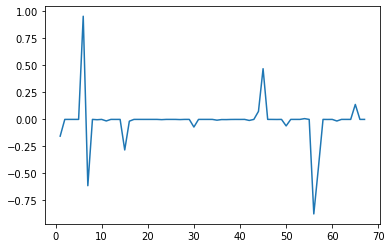

In [10]:
train_dataframe = pd.read_csv('train_set.csv')
nn = NeuralNetwork(len(unique_words), (len(unique_words)+1)//2, 1, 0.01)

errors = nn.train(train_dataframe, 3)
plt.plot(range(1, len(errors) + 1), errors)
plt.show()

Now we will test the neural network with the test set and finally display its acuaracy. presicion and recal

In [15]:
acuaracy = 0
confusion_matrix = [[0 for i in range(2)] for i in range(2)]

for index, row in test_set.iterrows():
    #print(row['message'])
    input_v = Data.get_inputs_count(row['message'],unique_words)
    result = round(nn.feedforward(input_v)[0,0])

    if row['label_tag'] == result:
         acuaracy+=1
    confusion_matrix[row['label_tag']][int(result)] +=1
    #print(row['class'], result,'\n')

acuaracy /= len(test_set)
presicion = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
recal = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])

print(acuaracy)
print(presicion)
print(recal)
print(confusion_matrix)

0.9569120287253142
0.9098360655737705
0.75
[[955, 11], [37, 111]]


In [12]:
tf_idf = Data.tf_idf("Call from 08702490080 - tells u 2 call 09066358152 to claim ?5000 prize. U have 2 enter all ur mobile & personal details @ the prompts. Careful!")
pd.DataFrame.from_dict(tf_idf)

,call,tell,claim,prize,enter,mobile,personal,detail,prompt,careful
0,0.439445,0.219722,0.219722,0.219722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.219722,0.219722,0.219722,0.219722,0.219722,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612


Finally we wil save the model in a pkl file

In [13]:
with open('nn.pkl', 'wb') as output:
    pickle.dump(nn, output)

In [14]:
output = open('nn.pkl', 'rb')
nn = pickle.load(output)
output.close()